In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests

### **MobileNetV2 Architecture Overview**
MobileNetV2 is a lightweight deep neural network designed for mobile and resource-constrained environments. It builds upon the principles of MobileNetV1 with **depthwise separable convolutions** and introduces **bottleneck blocks** and **inverted residuals** for better efficiency and performance.

#### **Key Features**
1. **Inverted Residuals**:
   - The block expands the input channels using a 1x1 convolution (expansion), applies a depthwise convolution, and then projects it back to a lower-dimensional space using another 1x1 convolution.
   - Skip connections are used for residual learning when input and output dimensions match.

2. **Linear Bottlenecks**:
   - Instead of a ReLU activation after the projection, a linear activation is used to retain information in low-dimensional spaces.

3. **Depthwise Separable Convolutions**:
   - Separate depthwise and pointwise convolutions reduce the computational cost compared to standard convolutions.

4. **Width Multiplier (`α`)**:
   - A hyperparameter to control the network's width, allowing a trade-off between accuracy and computational cost.

---

### **Input Size**
- MobileNetV2 typically accepts images of size **224x224x3** (Height x Width x Channels).
- The model can be trained with other input sizes (e.g., 192x192, 160x160) to reduce computational requirements.

---

### **Preprocessing Needed for Input**
1. **Resizing**: 
   - Resize the input image to the required size (e.g., 224x224).

2. **Normalization**: 
   - Convert pixel values from [0, 255] to [0, 1].
   - Normalize the pixel values using mean and standard deviation:

     $$x' = \frac{x - \mu}{\sigma}$$
     
     Commonly used values for mean $\mu$ and std  $\sigma$ are:
     - $\mu = [0.485, 0.456, 0.406]$
     - $\sigma = [0.229, 0.224, 0.225]$ (ImageNet statistics).

---

### **Output Size**
- The output size depends on the number of classes in the dataset.
- For ImageNet classification (default), the output is a **vector of size 1000** (representing probabilities for 1000 classes).
- For transfer learning or custom datasets, the output size corresponds to the number of classes in the new dataset.lications.

In [2]:
# Load the pre-trained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v2.eval()

# Load the image from the URL
url = 'https://www.garnelio.de/media/image/d0/61/5c/goldfisch-normalAJ8vh29hu0DJe.jpg'
response = requests.get(url)
image = Image.open(requests.get(url, stream=True).raw)

# Display the image
image.show()

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Apply preprocessing
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Perform inference with MobileNetV2
with torch.no_grad():
    output = mobilenet_v2(input_tensor)

# Convert logits to probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top 3 class indices and their probabilities
top3_prob, top3_indices = torch.topk(probabilities, 3)

# Download ImageNet class labels
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(imagenet_labels_url)
imagenet_classes = response.json()  # Parse JSON into a Python list

# Get class names and probabilities
top3_classes = [(imagenet_classes[idx], prob.item()) for idx, prob in zip(top3_indices, top3_prob)]

# Print the results
print("Top 3 Predictions:")
for class_name, prob in top3_classes:
    print(f"{class_name}: {prob * 100:.4f}%")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s] 
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/us

Top 3 Predictions:
goldfish: 99.9980%
tench: 0.0007%
rock beauty: 0.0005%


In [3]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:
def train(model, train_loader,val_loader, optimizer, criterion, num_epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    for epoch in range(num_epoch):
        running_loss = 0
        correct = 0
        total = 0
        model.train()

        # Training
        for i, (data, target) in enumerate(train_loader,0):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(output.data, 1)

            total += target.size(0)
            correct += (pred == target).sum().item()
            running_loss += loss.item()

        train_avg_loss = running_loss / (i+1)
        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)
        train_loss.append(train_avg_loss)

        # Validation
        model.eval()
        val_running_loss, val_corrects, val_total = 0, 0, 0

        for j,(inputs, labels) in enumerate(val_loader,0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item()
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)

        val_epoch_loss = val_running_loss / (j+1)
        val_epoch_acc = 100 * val_corrects / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epoch} - "
              f"Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.4f}%")


    return train_acc, train_loss, val_acc, val_loss



def test(model,train_loader,val_loader, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    dataLoader= [train_loader,val_loader,test_loader]
    for data_loader in dataLoader:
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for i, (data, target) in enumerate(data_loader,0):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, pred = torch.max(output.data, 1)
                val_loss += loss.item()
                total += target.size(0)
                correct += (pred == target).sum().item()
        accuracy = 100 * correct / total
        avg_loss = val_loss / (i+1)
        if data_loader == train_loader:
            print(f"Train Accuracy: {accuracy:.2f}%, Train Loss: {avg_loss:.4f}")
        elif data_loader == val_loader:
            print(f"Validation Accuracy: {accuracy:.2f}%, Validation Loss: {avg_loss:.4f}")
        else:
            print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_loss:.4f} \n")

# Calculate number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_learnable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# Load Dataset
train_set = Flowers102(root='./data', split='test', download=True, transform=train_transform)
val_set = Flowers102(root='./data', split='val', download=True, transform=val_test_transform)
test_set = Flowers102(root='./data', split='train', download=True, transform=val_test_transform)

# Dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

100%|██████████| 344862509/344862509 [00:09<00:00, 34518101.70it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 383313.42it/s]


100%|██████████| 14989/14989 [00:00<00:00, 7850702.13it/s]


In [6]:
# MobileNet-v2
mobilenet = models.mobilenet_v2(pretrained=True)
for param in mobilenet.parameters():
    param.requires_grad = False
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier = nn.Linear(num_ftrs, 102)

# VGG16
vgg = models.vgg16(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 102)

# ResNet50
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 102)

# Define the loss function
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date we

In [7]:
num_epoch = 20
# Mobilenet train, val
print('MobileNet-v2 :')
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)
mobil_train_acc, mobil_train_loss, mobil_val_acc, mobil_val_loss =train(mobilenet, train_loader, val_loader, optimizer, criterion, num_epoch)

MobileNet-v2 :
Epoch 1/20 - Train Loss: 2.6077, Train Accuracy: 49.4552%, Val Loss: 1.7043, Val Accuracy: 66.5686%
Epoch 2/20 - Train Loss: 0.9359, Train Accuracy: 83.9486%, Val Loss: 0.9701, Val Accuracy: 81.8627%
Epoch 3/20 - Train Loss: 0.5828, Train Accuracy: 89.5105%, Val Loss: 0.7925, Val Accuracy: 82.9412%
Epoch 4/20 - Train Loss: 0.4548, Train Accuracy: 91.6409%, Val Loss: 0.6884, Val Accuracy: 85.4902%
Epoch 5/20 - Train Loss: 0.3630, Train Accuracy: 93.1208%, Val Loss: 0.6272, Val Accuracy: 85.3922%
Epoch 6/20 - Train Loss: 0.3242, Train Accuracy: 93.9014%, Val Loss: 0.5790, Val Accuracy: 86.1765%
Epoch 7/20 - Train Loss: 0.2748, Train Accuracy: 94.6007%, Val Loss: 0.5429, Val Accuracy: 86.5686%
Epoch 8/20 - Train Loss: 0.2430, Train Accuracy: 95.2025%, Val Loss: 0.5152, Val Accuracy: 87.7451%
Epoch 9/20 - Train Loss: 0.2128, Train Accuracy: 95.5603%, Val Loss: 0.4997, Val Accuracy: 87.6471%
Epoch 10/20 - Train Loss: 0.1931, Train Accuracy: 96.3571%, Val Loss: 0.4974, Val Acc

In [8]:
num_epoch = 20
# VGG train, val
print('VGG16 :')
optimizer = optim.Adam(vgg.parameters(), lr=0.001)
vgg_train_acc, vgg_train_loss, vgg_val_acc, vgg_val_loss = train(vgg, train_loader,val_loader, optimizer, criterion, num_epoch)

VGG16 :
Epoch 1/20 - Train Loss: 2.3930, Train Accuracy: 45.9587%, Val Loss: 1.5146, Val Accuracy: 63.0392%
Epoch 2/20 - Train Loss: 1.1822, Train Accuracy: 69.2796%, Val Loss: 1.1117, Val Accuracy: 73.6275%
Epoch 3/20 - Train Loss: 0.9766, Train Accuracy: 73.2965%, Val Loss: 0.9972, Val Accuracy: 75.0000%
Epoch 4/20 - Train Loss: 0.8758, Train Accuracy: 75.8009%, Val Loss: 0.8815, Val Accuracy: 78.0392%
Epoch 5/20 - Train Loss: 0.7925, Train Accuracy: 77.8988%, Val Loss: 0.8536, Val Accuracy: 77.4510%
Epoch 6/20 - Train Loss: 0.7622, Train Accuracy: 77.8175%, Val Loss: 0.8048, Val Accuracy: 78.2353%
Epoch 7/20 - Train Loss: 0.7141, Train Accuracy: 78.9397%, Val Loss: 0.7991, Val Accuracy: 78.9216%
Epoch 8/20 - Train Loss: 0.6933, Train Accuracy: 80.6147%, Val Loss: 0.7874, Val Accuracy: 78.4314%
Epoch 9/20 - Train Loss: 0.6631, Train Accuracy: 80.8099%, Val Loss: 0.7616, Val Accuracy: 78.6275%
Epoch 10/20 - Train Loss: 0.6413, Train Accuracy: 81.2165%, Val Loss: 0.7876, Val Accuracy: 

In [9]:
num_epoch = 20
# ResNet train, val, test
print('ResNet50 :')
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
resnet_train_acc, resnet_train_loss, resnet_val_acc, resnet_val_loss = train(resnet, train_loader,val_loader, optimizer, criterion, num_epoch)


ResNet50 :
Epoch 1/20 - Train Loss: 2.6614, Train Accuracy: 47.6663%, Val Loss: 1.7798, Val Accuracy: 62.3529%
Epoch 2/20 - Train Loss: 1.0224, Train Accuracy: 81.3791%, Val Loss: 1.0775, Val Accuracy: 76.8627%
Epoch 3/20 - Train Loss: 0.6559, Train Accuracy: 86.9247%, Val Loss: 0.7503, Val Accuracy: 84.3137%
Epoch 4/20 - Train Loss: 0.5060, Train Accuracy: 90.0146%, Val Loss: 0.6778, Val Accuracy: 84.5098%
Epoch 5/20 - Train Loss: 0.4090, Train Accuracy: 91.6084%, Val Loss: 0.5734, Val Accuracy: 86.5686%
Epoch 6/20 - Train Loss: 0.3625, Train Accuracy: 92.7305%, Val Loss: 0.5590, Val Accuracy: 86.3725%
Epoch 7/20 - Train Loss: 0.3142, Train Accuracy: 93.4298%, Val Loss: 0.5085, Val Accuracy: 86.9608%
Epoch 8/20 - Train Loss: 0.2660, Train Accuracy: 94.8122%, Val Loss: 0.4792, Val Accuracy: 87.6471%
Epoch 9/20 - Train Loss: 0.2494, Train Accuracy: 94.3568%, Val Loss: 0.4785, Val Accuracy: 87.2549%
Epoch 10/20 - Train Loss: 0.2323, Train Accuracy: 94.8284%, Val Loss: 0.4506, Val Accurac

In [10]:
# Mobilenet test
print('MobileNet-v2 :')
test(mobilenet,train_loader,val_loader, test_loader, criterion)

# VGG test
print('VGG16 :')
test(vgg,train_loader,val_loader, test_loader, criterion)

# ResNet test
print('ResNet50 :')
test(resnet,train_loader,val_loader, test_loader, criterion)


MobileNet-v2 :
Train Accuracy: 98.73%, Train Loss: 0.0741
Validation Accuracy: 89.41%, Validation Loss: 0.4477
Test Accuracy: 87.55%, Test Loss: 0.4415 

VGG16 :
Train Accuracy: 93.76%, Train Loss: 0.2332
Validation Accuracy: 81.08%, Validation Loss: 0.7041
Test Accuracy: 79.12%, Test Loss: 0.8290 

ResNet50 :
Train Accuracy: 97.98%, Train Loss: 0.0951
Validation Accuracy: 88.82%, Validation Loss: 0.4178
Test Accuracy: 87.06%, Test Loss: 0.4370 



In [11]:
print('Number of parameters in MobileNet-v2: ', count_parameters(mobilenet))
print('Number of learnable parameters in MobileNet-v2: ', count_learnable_parameters(mobilenet))

print('Number of parameters in VGG16: ', count_parameters(vgg))
print('Number of learnable parameters in VGG16: ', count_learnable_parameters(vgg))

print('Number of parameters in ResNet50: ', count_parameters(resnet))
print('Number of learnable parameters in ResNet50: ', count_learnable_parameters(resnet))

Number of parameters in MobileNet-v2:  2354534
Number of learnable parameters in MobileNet-v2:  130662
Number of parameters in VGG16:  134678438
Number of learnable parameters in VGG16:  417894
Number of parameters in ResNet50:  23717030
Number of learnable parameters in ResNet50:  208998


## Accuracy:
**MobileNet-v2 > ResNet50 > VGG16**

## Number of parameters:
**VGG16 > ResNet50 > MobileNet-v2**

## Number of learnable parameters:
**VGG16 > ResNet50 > MobileNet-v2**

- This suggests that if we could continue training or had a larger dataset, we could get a better result from VGG net.


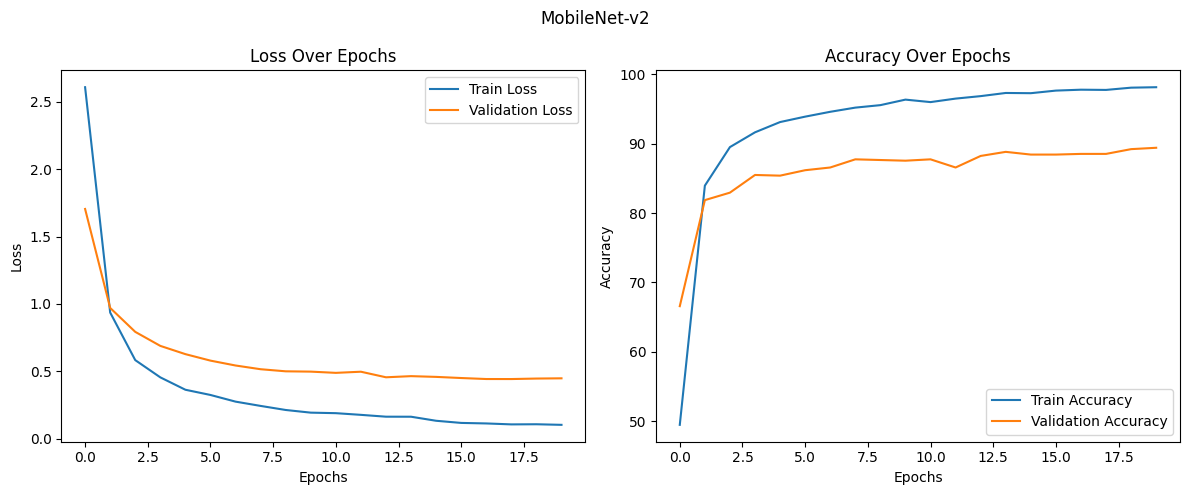

In [12]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mobil_train_loss, label="Train Loss")
plt.plot(mobil_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(mobil_train_acc, label="Train Accuracy")
plt.plot(mobil_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.suptitle("MobileNet-v2")
plt.legend()

plt.tight_layout()
plt.show()


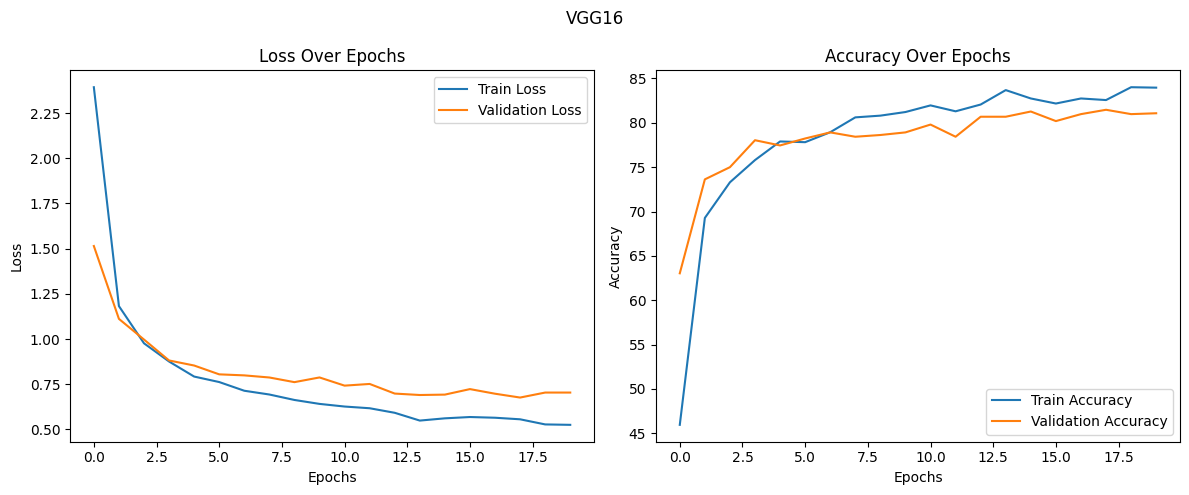

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_train_loss, label="Train Loss")
plt.plot(vgg_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(vgg_train_acc, label="Train Accuracy")
plt.plot(vgg_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.suptitle("VGG16")
plt.legend()

plt.tight_layout()
plt.show()

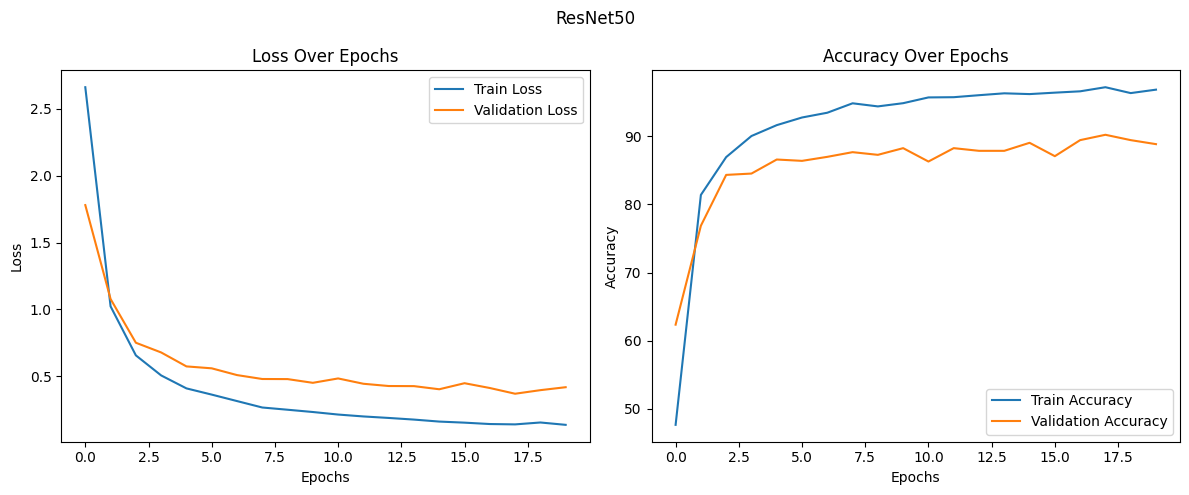

In [14]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_train_loss, label="Train Loss")
plt.plot(resnet_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(resnet_train_acc, label="Train Accuracy")
plt.plot(resnet_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.suptitle("ResNet50")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# MobileNet-v2
mobilenet_rand = models.mobilenet_v2(pretrained=False)
num_ftrs = mobilenet_rand.classifier[1].in_features
mobilenet_rand.classifier = nn.Linear(num_ftrs, 102)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
num_epoch = 20
# Mobilenet train, val
print('MobileNet-v2 :')
optimizer = optim.Adam(mobilenet_rand.parameters(), lr=0.001)
rmobil_train_acc, rmobil_train_loss, rmobil_val_acc, rmobil_val_loss =train(mobilenet_rand, train_loader, val_loader, optimizer, criterion, num_epoch)

MobileNet-v2 :
Epoch 1/20 - Train Loss: 3.8616, Train Accuracy: 11.6279%, Val Loss: 4.6187, Val Accuracy: 6.9608%
Epoch 2/20 - Train Loss: 3.1234, Train Accuracy: 21.7596%, Val Loss: 3.7414, Val Accuracy: 16.7647%
Epoch 3/20 - Train Loss: 2.7151, Train Accuracy: 28.5575%, Val Loss: 3.1334, Val Accuracy: 21.0784%
Epoch 4/20 - Train Loss: 2.3949, Train Accuracy: 35.3879%, Val Loss: 3.1963, Val Accuracy: 21.8627%
Epoch 5/20 - Train Loss: 2.1229, Train Accuracy: 41.4539%, Val Loss: 3.0539, Val Accuracy: 25.5882%
Epoch 6/20 - Train Loss: 1.9280, Train Accuracy: 46.5279%, Val Loss: 2.3662, Val Accuracy: 37.9412%
Epoch 7/20 - Train Loss: 1.6690, Train Accuracy: 53.2444%, Val Loss: 2.1381, Val Accuracy: 43.4314%
Epoch 8/20 - Train Loss: 1.5517, Train Accuracy: 55.5375%, Val Loss: 2.5194, Val Accuracy: 36.6667%
Epoch 9/20 - Train Loss: 1.3978, Train Accuracy: 59.9122%, Val Loss: 2.2871, Val Accuracy: 42.8431%
Epoch 10/20 - Train Loss: 1.2657, Train Accuracy: 63.3924%, Val Loss: 1.7243, Val Accu

In [17]:
# Mobilenet test
print('MobileNet-v2 randomly initialized :')
test(mobilenet_rand,train_loader,val_loader, test_loader, criterion)

MobileNet-v2 randomly initialized :
Train Accuracy: 86.65%, Train Loss: 0.4456
Validation Accuracy: 70.59%, Validation Loss: 1.1896
Test Accuracy: 70.10%, Test Loss: 1.2083 



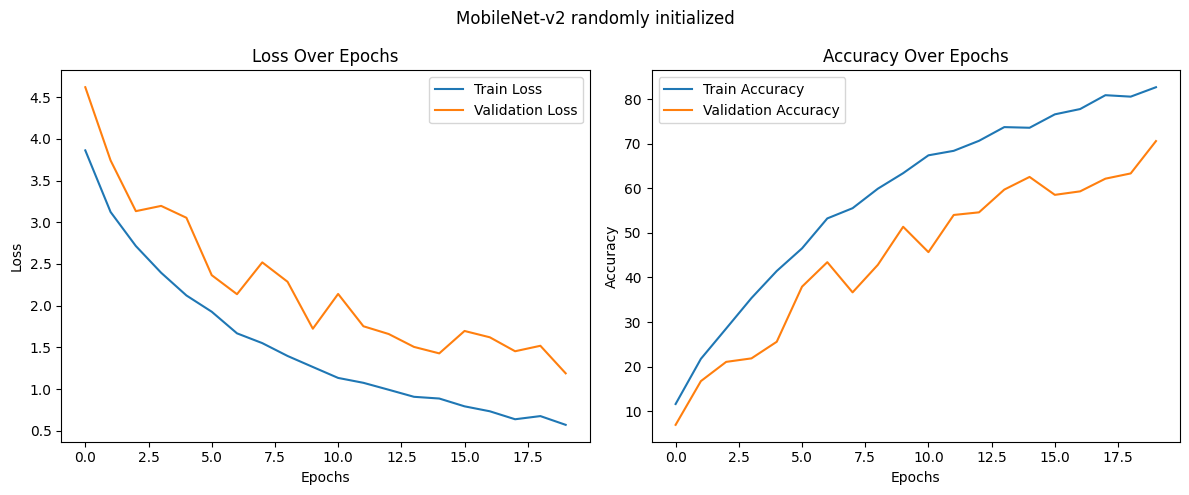

In [18]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rmobil_train_loss, label="Train Loss")
plt.plot(rmobil_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(rmobil_train_acc, label="Train Accuracy")
plt.plot(rmobil_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.suptitle("MobileNet-v2 randomly initialized")
plt.legend()

plt.tight_layout()
plt.show()


We can see better learning curve and accuracy on test set for the same number of epochs for pretrained model. Also in pretrained models, accuracy on the training set started from 50% and  then easily increased in 2nd epoch to 70% or 80%; but in non-pretrained model, it took more than 15 epochs of training to reach that accuracy on training set (it started form 11%).

For equal number of epochs, as we can see, pretrained MobileNet-V2 model reaches 88% of accuracy but randomly initialized model reaches 70% of accuracy (about 20% poorer).